# Test scripts on command line
Use this notebook as a test space

In [1]:
from platform import python_version
python_version()
import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
from pyproj import CRS, Transformer


/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [70]:
!python /projects/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m run_LC_height_thresholds -o /projects/my-private-bucket/

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:  ATL08

Output dir:  /projects/my-public-bucket/DPS_tile_lists
# of duplicate tiles: 46584
Final # of tiles: 46166
df shape :                                              s3_path  ... tile_num
0  s3://maap-ops-workspace/lduncanson/dps_output/...  ...       NA
1  s3://maap-ops-workspace/lduncanson/dps_output/...  ...       NA
2  s3://maap-ops-workspace/lduncanson/dps_output/...  ...       NA
3  s3://maap-ops-workspace/lduncanson/dps_output/...  ...       NA
4  s3://maap-ops-workspace/lduncanson/dps_output/...  ...       NA

[5 rows x 4 columns]
Writing tindex master csv: /projects/my-public-bucket/DPS_tile_lists/ATL08_tindex_master.csv


,id,key,s3,geometry
0,Copernicus_DSM_COG_10_N80_00_W104_00_DEM,Copernicus_DSM_COG_10_N80_00_W104_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-104.00069 80.00014, -104.00069 81.0..."
1,Copernicus_DSM_COG_10_N80_00_W103_00_DEM,Copernicus_DSM_COG_10_N80_00_W103_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-103.00069 80.00014, -103.00069 81.0..."
2,Copernicus_DSM_COG_10_N80_00_W102_00_DEM,Copernicus_DSM_COG_10_N80_00_W102_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-102.00069 80.00014, -102.00069 81.0..."
3,Copernicus_DSM_COG_10_N80_00_W101_00_DEM,Copernicus_DSM_COG_10_N80_00_W101_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-101.00069 80.00014, -101.00069 81.0..."
4,Copernicus_DSM_COG_10_N80_00_W100_00_DEM,Copernicus_DSM_COG_10_N80_00_W100_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-100.00069 80.00014, -100.00069 81.0..."


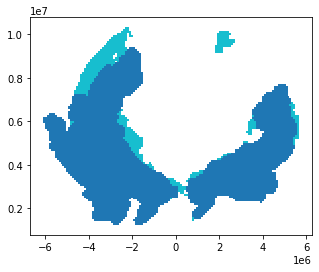

In [6]:
import geopandas

dem_tiles_index_path = '/projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson'
dem_tiles_index = geopandas.read_file(dem_tiles_index_path)
dem_tiles_index['tile_num'] = dem_tiles_index.index

boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
boreal_tile_index = geopandas.read_file(boreal_tile_index_path)
boreal_tile_index.plot(column='tile_version')

#boreal_tile_index[boreal_tile_index.tile_version=='version 2']

In [2]:
dem_tiles_index.tile_num.to_list().sort()

NameError: name 'dem_tiles_index' is not defined

In [ ]:
import sys
sys.path.append('/projects/icesat2_boreal/lib')
import maplib_folium

In [2]:
TILE_NUM = 131

In [22]:
args = f"--in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 120 \
--in_tile_layer boreal_tiles_v003 \
-o /projects/test_data/ \
--topo_tile_fn /projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson"
!python /projects/icesat2_boreal/lib/3.1.5_dps.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The DEM filename(s) intersecting the 120 m bbox for tile id 42935:
 s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N63_00_W171_00_DEM/Copernicus_DSM_COG_10_N63_00_W171_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N63_00_W172_00_DEM/Copernicus_DSM_COG_10_N63_00_W172_00_DEM.tif
Orig stack shape:  (1, 3008, 3008)
Output resolution:  (30, 30)
Writing img to memory...
/projects/icesat2_boreal/lib/3.1.5_dps.py:120: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  write_cog(mosaic, dem_cog_fn, tile_parts['tile_crs'], out_trans, ["elevation"], out_crs=tile_parts['tile_c

In [14]:
!pip install pystac_client

TILE_NUM = 12967
INDEX_FN = '/projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson'#
INDEX_LYR = 'dem30m_tiles_v2'

TILE_NUM = 3421
INDEX_FN = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
INDEX_LYR = 'boreal_tiles_v003'

args = f"-i {INDEX_FN} \
--in_tile_num {TILE_NUM} \
-lyr {INDEX_LYR} \
-o /projects/test_data \
-a https://cmr.earthdata.nasa.gov/stac/LPCLOUD \
--tile_buffer_m 0 \
-sy 2020 -ey 2021 -smd 06-01 -emd 06-15 -mc 40 -t HLS"
!python 3.1.2_dps.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
06-01
geopkg path =  /projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson
tile number =  12967
output resolution =  30
in_bbox =  [-15.000138888888898, 13.000138888888884, -14.000138888888898, 14.000138888888884]
get HLS data
run function
opening client
start_month_day 06-01
start date, end date =  2020-06-01T00:00:00Z 2020-06-15T23:59:59Z
conducting search
initial results =  4
filtered results =  4
opening client
start_month_day 06-01
start date, end date =  2021-06-01T00:00:00Z 2021-06-15T23:59:59Z
conducting search
initial results =  8
filtered results =  7
4
Number of files per band = 11
s3://lp-prod-protected/HLSL30.020/HLS.L30.T28PDA.2020159T112051.v2.0/HLS.L30.T28PDA.2020159T

In [9]:
%%time
args = f"\
-LC_filter True \
--extract_covars \
--do_30m \
--do_dps \
-years_list 2019 2020 2021 \
-o /projects/my-public-bucket/atl08_filt_covar_tiles \
-in_tile_num {TILE_NUM} \
-in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg \
-in_tile_layer boreal_tiles_v003 \
-in_tile_id_col tile_num \
-csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv \
-topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv \
-landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Landsat_tindex_master.csv \
-user_stacks nathanmthomas \
-user_atl08 lduncanson \
-thresh_sol_el 5 \
-v_ATL08 5 -minmonth 4 -maxmonth 10"
print(args)
!python /projects/icesat2_boreal/lib/tile_atl08.py $args

--updated_filters --extract_covars --do_30m --do_dps -years_list 2019 2020 2021 -o /projects/my-public-bucket/atl08_filt_covar_tiles -in_tile_num 10 -in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg -in_tile_layer boreal_tiles_v003 -in_tile_id_col tile_num -csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv -topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv -landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Landsat_tindex_master.csv -user_stacks nathanmthomas -user_atl08 lduncanson -thresh_sol_el 5 -v_ATL08 5 -minmonth 4 -maxmonth 10
/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Working on tile:	 10
From